## Tsfresh data preparation


In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as imb_pipe


In [4]:
df = pd.read_csv('data/data_processed/client_data.csv')

In [ ]:
merged_df = df.copy()

In [6]:
#drop the columns
merged_df.drop("creation_date", axis=1, inplace=True)

In [7]:
# Convert invoice_date to datetime
merged_df

In [ ]:
#defining the target variable and features
target = ['target']
num_features = ['client_id',
                '1transactions_count',
                'consumption_level_1_mean',
                'consumption_level_2_mean',
                'consumption_level_3_mean',
                'consumption_level_4_mean']
cat_features = [col for col in merged_df.columns if col not in num_features and col not in target]

In [ ]:
#preprocessing categorical features
cat_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('one_hot_encoding', OneHotEncoder())
])

In [ ]:
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_features),
    #('num', num_pipeline, num_features)
], remainder='passthrough')

In [ ]:
df = merged_df.copy()
X = df.drop(columns=["target"], axis=1)  
y = df["target"]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
# unbalanced dataset?
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

In [ ]:
model_stage1 = XGBClassifier()
                            # n_estimators=500, 
                            #  random_state=42,
                            #  max_depth=5,        # avoids overfitting
                            # learning_rate=0.05, # Slow learning
                            # subsample=0.8,      # randomness
                            # colsample_bytree=0.8, 
                            # scale_pos_weight=scale_pos_weight,  # Adjust based on fraud ratio
                            # eval_metric="aucpr") 

In [ ]:
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model_stage1) 
])

In [16]:
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('one_hot_encoding',
                                                                   OneHotEncoder())]),
                                                  ['disrict', 'client_catg',
                                                   'region'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_byle...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [17]:
# Train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('one_hot_encoding',
                                                                   OneHotEncoder())]),
                                                  ['disrict', 'client_catg',
                                                   'region'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_byle...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [18]:
ros = RandomOverSampler(random_state=10, sampling_strategy='auto') 

# pipeline
ros_pipeline = imb_pipe(ros, model_pipeline)



,disrict,client_catg,region,1transactions_count,consumption_level_1_mean,consumption_level_2_mean,consumption_level_3_mean,consumption_level_4_mean
52667,63,11,311,73,240.657534,17.780822,2.808219,0.000000
44198,63,11,311,33,46.939394,2.515152,0.000000,0.000000
33454,63,11,311,58,215.275862,27.586207,22.879310,91.086207
47946,60,11,101,33,346.363636,0.060606,0.000000,0.000000
113031,63,11,306,6,323.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
110268,63,11,313,37,505.837838,16.216216,19.189189,18.216216
119879,62,11,301,5,2.400000,0.000000,0.000000,0.000000
103694,69,11,104,4,642.000000,46.500000,0.000000,0.000000
131932,63,11,306,22,313.409091,0.000000,0.000000,0.000000


In [ ]:
ros_pipeline.fit(X_train, y_train)

In [ ]:
ros_pipeline.score(X_test, y_test)

In [ ]:
# Define the hyperparameter search space
param_distributions = {
    'pipeline__model__n_estimators': np.arange(50, 500, 50),
    'pipeline__model__max_depth': np.arange(3, 10),
    'pipeline__model__learning_rate': np.logspace(-3, 0, 10),
    'pipeline__model__subsample': np.linspace(0.5, 1, 5),
    'pipeline__model__scale_pos_weight': [0]
}

# Define RandomizedSearchCV
random_search = RandomizedSearchCV(
    ros_pipeline, param_distributions,
    n_iter=20,  # Number of random samples
    scoring='roc_auc',  # Optimize for F1-score
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all CPUs
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

In [ ]:
#extracting the best model
best_model = random_search.best_estimator_

In [ ]:
#classification report of best model
y_pred = best_model.predict(X_test) 
print(classification_report(y_test, y_pred))

In [ ]:
#confusion matrix of best model
confusion_matrix(y_test, y_pred)

In [ ]:
# Make predictions
y_pred = model_pipeline.predict(X_test)

# Output predictions
print("Predictions:", y_pred)

In [ ]:
# confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
# # probabilities for fraud
fraud_probs_stage1 = model_pipeline.predict_proba(X_test)[:, 1]  

# Fraud probabilities for second stage model > 50%
# 1st stage: optimize recall, 2nd stage optimize precision
suspicious_cases = X_test[fraud_probs_stage1 > 0.30] # only use propabilities larger 30% for2nd stage model

# not needed 
y_suspicious = y_test[fraud_probs_stage1 > 0.30] # snot used

In [23]:
# decision tree for second stage
dt_model_stage2 = LogisticRegression(C=0.1, 
    penalty='l1', 
    solver='liblinear', 
    class_weight='balanced', 
    max_iter=500)
dt_model_stage2.fit(suspicious_cases, y_suspicious)

fraud_probs_stage2 = dt_model_stage2.predict_proba(suspicious_cases)[:, 1]

# categorize risk
def risk_category(prob):
    if prob > 0.7:
        return "High Risk"
    elif prob > 0.4:
        return "Medium Risk"
    else:
        return "Low Risk"

suspicious_cases_output = suspicious_cases.copy()
suspicious_cases_output["Risk Level"] = [risk_category(p) for p in fraud_probs_stage2]


In [ ]:
high_risk_cases = suspicious_cases_output#[suspicious_cases_output["Risk Level"] == "High Risk"]
print(high_risk_cases.head())

In [ ]:
# plot high risk for each risk level barplot count
high_risk_cases["Risk Level"].value_counts().plot(kind='bar')

Text(0.5, 1.0, 'Sentinel Risk Assessor$^{TM}$')

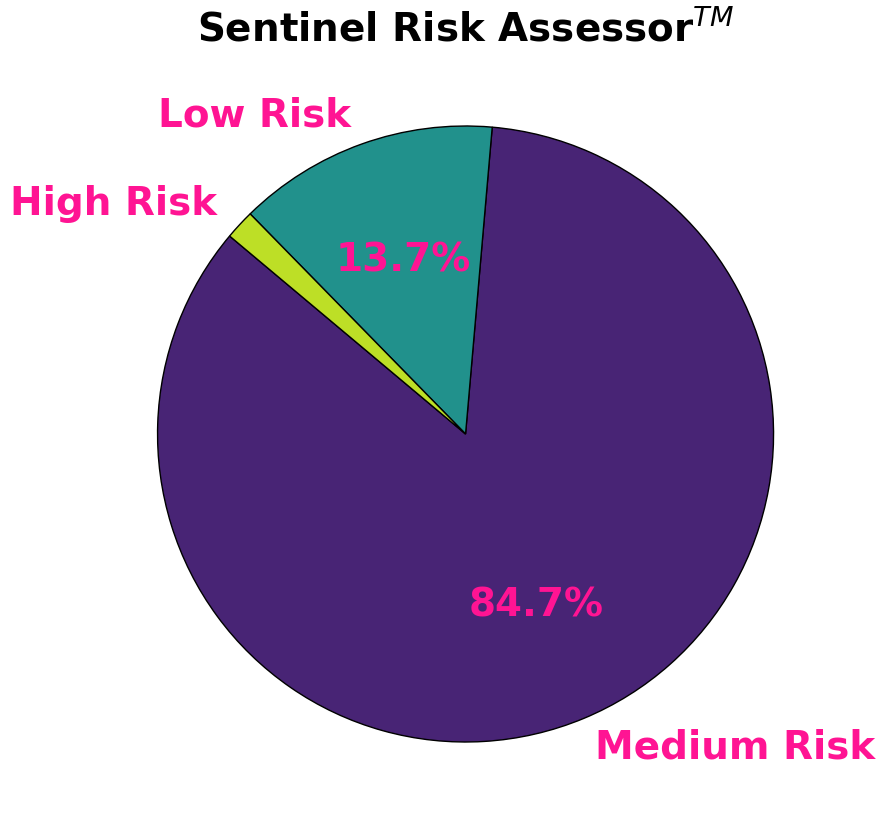

In [43]:
import matplotlib.cm as cm

# Count occurrences of each Risk Level
risk_counts = high_risk_cases['Risk Level'].value_counts()

# Define a function to filter small percentages
def autopct_format(pct):
    return f'{pct:.1f}%' if pct >= 3 else ''  # Hide values <5%

# Generate distinct, high-contrast colors from Viridis
num_categories = len(risk_counts)
color_indices = np.linspace(0.1, 0.9, num_categories)  # Evenly spaced values for contrast
colors = [cm.viridis(i) for i in color_indices]  # Extract colors

# Set larger font size globally
plt.rcParams.update({'font.size': 28})

# Plot the pie chart
plt.figure(figsize=(10, 10))
plt.pie(risk_counts, labels=risk_counts.index, autopct=autopct_format, 
        colors=colors, startangle=140, wedgeprops={'edgecolor': 'black'}, 
        textprops={'fontsize': 28, 'color': 'deeppink','fontweight': 'bold'})  # Pink text)  # Larger text

plt.title("Sentinel Risk Assessor$^{TM}$", fontsize=28, fontweight='bold')  